<a href="https://colab.research.google.com/github/Pankaj-Tarone/HomeWork/blob/master/Combination_of_Unsupervised_Supervised_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Dense, UpSampling2D, Activation
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD,rmsprop,adadelta
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
from keras.utils import np_utils



```
########################### ****Define Number of classes, Batch size ,epochs for the model **** ##########################
```



In [0]:
batch_size = 32
num_classes = 10
epochs = 150

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

############################   *Data Normailazation* ############################

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]

In [0]:
shape_x = 32
shape_y = 32

In [0]:
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


###################### **Define Simple model of for Autoencoder** ######################

In [0]:
input_img = Input(shape=(shape_x, shape_y, 3))
# Ecoding
encoder = Conv2D(32, (3, 3), padding='same')(input_img)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(16, (3, 3), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoded = MaxPooling2D((2, 2), padding='same')(encoder)

# Decoding
decoder = Conv2D(16, (3, 3), padding='same')(encoded)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(32, (3, 3), padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(3, (3, 3), padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoded = Activation('relu')(decoder)
   

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error', metrics=["accuracy"])
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_56 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_75 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 16, 16)        64 

############################### **Training the Autoencoder Model** ###############################

In [0]:
autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    shuffle=True)

Train on 50000 samples, validate on 7000 samples
Epoch 1/150
50000/50000 [==============================] - 20s 395us/step - loss: 0.0186 - acc: 0.5985 - val_loss: 0.0095 - val_acc: 0.6448
Epoch 2/150
50000/50000 [==============================] - 16s 325us/step - loss: 0.0096 - acc: 0.6768 - val_loss: 0.0075 - val_acc: 0.7069
Epoch 3/150
50000/50000 [==============================] - 17s 335us/step - loss: 0.0080 - acc: 0.7117 - val_loss: 0.0064 - val_acc: 0.7462
Epoch 4/150
50000/50000 [==============================] - 17s 338us/step - loss: 0.0073 - acc: 0.7259 - val_loss: 0.0060 - val_acc: 0.7510
Epoch 5/150
50000/50000 [==============================] - 17s 333us/step - loss: 0.0068 - acc: 0.7337 - val_loss: 0.0057 - val_acc: 0.7454
Epoch 6/150
50000/50000 [==============================] - 17s 337us/step - loss: 0.0064 - acc: 0.7403 - val_loss: 0.0053 - val_acc: 0.7605
Epoch 7/150
50000/50000 [==============================] - 17s 330us/step - loss: 0.0061 - acc: 0.7453 - val_lo

###########################**Calculate The Score** ###########################

In [0]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print(score)

3000/3000 [==============================] - 0s 99us/step
[0.002409059212853511, 0.8306217449506124]


In [0]:
c10test = autoencoder.predict(x_test)
c10val = autoencoder.predict(x_val)

In [0]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

Cifar10_test: 0.4703737497329712
Cifar10_val: 0.47377893328666687


##################### **Fucntion to Visualize the Autoencoder output** #####################

In [0]:
# definition to show original image and reconstructed image
def fucntion_Encode_Decode(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


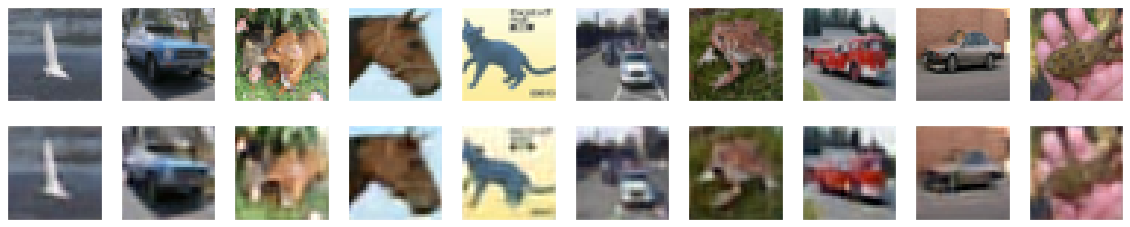

In [0]:
fucntion_Encode_Decode(x_test, c10test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


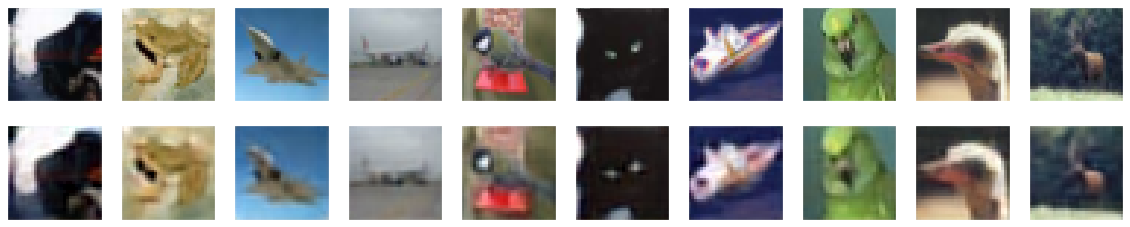

In [0]:
fucntion_Encode_Decode(x_test[100:], c10test[100:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


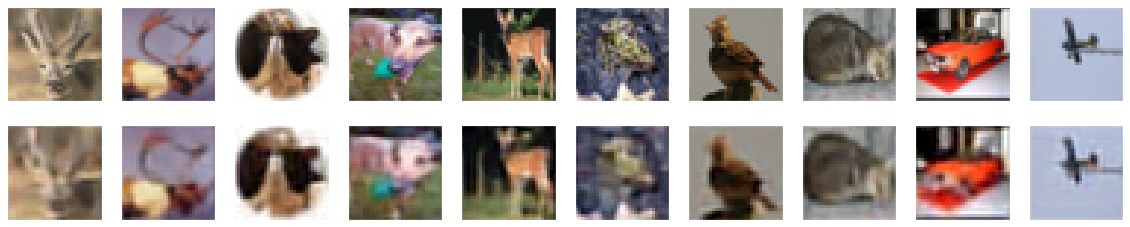

In [0]:
fucntion_Encode_Decode(x_test[200:], c10test[200:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


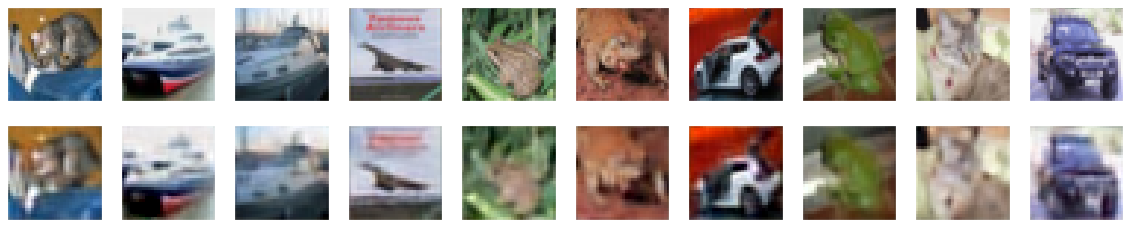

In [0]:
fucntion_Encode_Decode(x_val, c10val)

################## **Let's Save the model Weights** #################

In [0]:
autoencoder.save('pre_autoencoder.hdf5')

＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃　**Lets Start with Second Part of Experiment** ＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃


In [0]:
BATCH_NORM = False

batch_size = 32
num_classes = 10
epochs = 150
data_augmentation = True

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # x_train - training data(images), y_train - labels(digits)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']


# Convert and pre-processing

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


############### **Making data for CNN to feed from the Autoencoder** ###############


In [0]:

x_test = autoencoder.predict(x_test)
x_train = autoencoder.predict(x_train)


In [0]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


########################## **CNN Model** #######################

In [0]:
#second turn 

input_img = Input(shape=(shape_x, shape_y, 3))
def base_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
   
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Flatten())

    model.add(Dense(4096))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Dense(num_classes))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.001, decay=0, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

cnn_model = base_model()
cnn_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_80 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_81 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 128)      

########################## **Model Training** ############################

In [0]:
cnn = cnn_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), shuffle=True)


Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 24s 481us/step - loss: 2.2975 - acc: 0.1088 - val_loss: 2.2971 - val_acc: 0.1061
Epoch 2/150
50000/50000 [==============================] - 21s 420us/step - loss: 2.2591 - acc: 0.1156 - val_loss: 2.2583 - val_acc: 0.2457
Epoch 3/150
50000/50000 [==============================] - 21s 427us/step - loss: 2.0563 - acc: 0.2429 - val_loss: 2.1125 - val_acc: 0.2675
Epoch 4/150
50000/50000 [==============================] - 21s 418us/step - loss: 1.9695 - acc: 0.2758 - val_loss: 2.0903 - val_acc: 0.2938
Epoch 5/150
50000/50000 [==============================] - 21s 417us/step - loss: 1.9165 - acc: 0.3009 - val_loss: 2.0493 - val_acc: 0.3192
Epoch 6/150
50000/50000 [==============================] - 21s 418us/step - loss: 1.8522 - acc: 0.3290 - val_loss: 2.0092 - val_acc: 0.3695
Epoch 7/150
50000/50000 [==============================] - 21s 411us/step - loss: 1.7682 - acc: 0.3609 - val_l

######################## **Model Analysis** ##############################

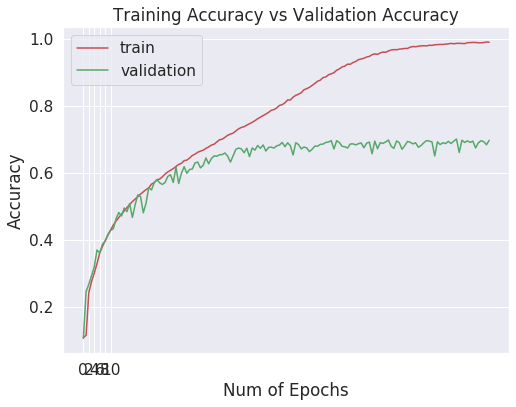

In [0]:
plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


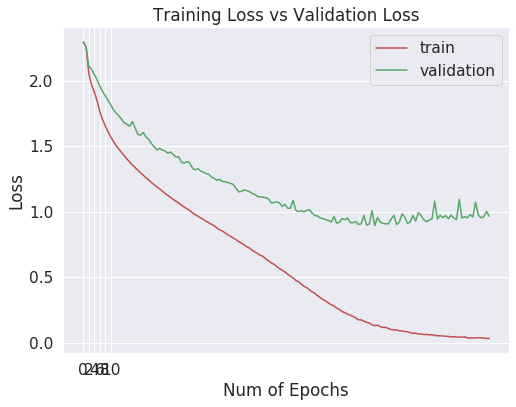

Accuracy: 69.65%
0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[815  15  38  12  15   3  12  14  48  28]
 [ 20 818  11   9   5   3  11   2  22  99]
 [ 86   4 581  42 109  47  69  36  10  16]
 [ 48  21  65 443  89 180  70  41  14  29]
 [ 40   5  84  33 666  38  57  59  13   5]
 [ 29   4  52 139  75 575  51  47  14  14]
 [ 16   9  39  34  68  30 778   7  10   9]
 [ 31   8  19  33  76  50  10 749   5  19]
 [ 81  47  16   9  10   7   6   1 791  32]
 [ 44  99  14  13   5  13   9  25  29 749]]


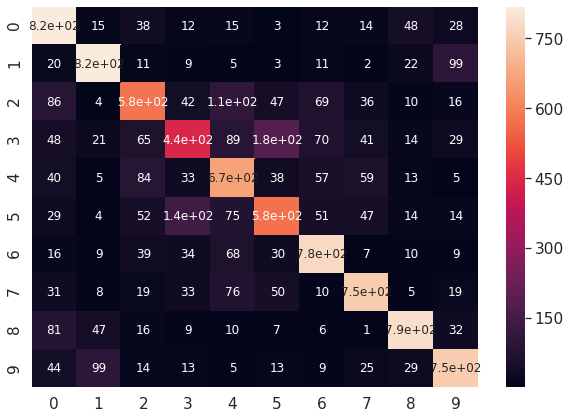

In [0]:
plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

scores = cnn_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_model.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

##########Checking Accuracy on Actual data of cifir-10##########


In [0]:
BATCH_NORM = False

batch_size = 32
num_classes = 10
epochs = 150
data_augmentation = True

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # x_train - training data(images), y_train - labels(digits)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']


# Convert and pre-processing

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
score = cnn_model.evaluate(x_test, y_test, verbose=1)
print(score)

10000/10000 [==============================] - 1s 139us/step
[0.94141911277771, 0.7111]
